# Efficient Online Learning of Contact Force Models for Connector Insertion *MuJoCo Demo*
**This colab accompanies our paper, available at [model-based-plugging.github.io](model-based-plugging.github.io).**

In this colab we use a simple toy connector insertion environment in MuJoCo to demonstrate the simplicity and effectiveness of the ideas proposed in our paper. This colab will work through the following main points of the paper:


*   The contact forces on the connector during insertion can be modeled with a simple linear function.
*   An estimate of this linear function can be solved for online with a novel Linear Model Learning (LML) algorithm.
*   A convex optimization control policy can use this linear model to guide the connector to a smooth insertion.


In [1]:
#%%capture

# @title Install MuJoCo
!pip install mujoco
#@title Check if installation was successful

# from google.colab import files

import distutils.util
import os
import subprocess
# if subprocess.run('nvidia-smi').returncode:
#   raise RuntimeError(
#       'Cannot communicate with GPU. '
#       'Make sure you are using a GPU Colab runtime. '
#       'Go to the Runtime menu and select Choose runtime type.')

# # Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# # This is usually installed as part of an Nvidia driver package, but the Colab
# # kernel doesn't install its driver via APT, and as a result the ICD is missing.
# # (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
# NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
# if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
#   with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
#     f.write("""{
#     "file_format_version" : "1.0.0",
#     "ICD" : {
#         "library_path" : "libEGL_nvidia.so.0"
#     }
# }
# """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

#@title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:


/tmp/ipykernel_206622/146634724.py:9: DeprecationWarning: The distutils package is deprecated and slated for removal in Python 3.12. Use setuptools or check PEP 632 for potential alternatives
  import distutils.util


Installation successful.
Installing mediapy:


In [2]:
# @title Load simple connector MJCF as `xml`
xml = """
<mujoco>
  <default>
    <geom density="1" solimp="0.0 0.1 0.1 0.5 2"/>
    <!-- <geom solimp="0.0 0.1 0.1 0.5 2" /> -->
  </default>

  <visual>
    <map force="0.1"/>
    <headlight ambient="0.7 0.7 0.7"/>
    <rgba contactforce="0.7 1.0 1.0 .6"/>
  </visual>

  <visual>
  <global offwidth="1024" offheight="1024"/>
  <rgba haze="0.15 0.25 0.35 1"/>
</visual>


  <option>
    <flag gravity="disable"/>
  </option>


<asset>
    <texture type="skybox" builtin="gradient" rgb1=".3 .5 .7" rgb2="0 0 0" width="32" height="512"/>
    <texture name="body" type="cube" builtin="flat" mark="cross" width="128" height="128" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" markrgb="1 1 1" random="0.01"/>
    <material name="body" texture="body" texuniform="true" rgba="0.8 0.6 .4 1"/>
    <texture name="grid" type="2d" builtin="checker" width="512" height="512" rgb1=".1 .2 .3" rgb2=".2 .3 .4"/>
    <material name="grid" texture="grid" texrepeat="1 1" texuniform="true" reflectance="0."/>
  </asset>

  <worldbody>
    <light diffuse=".5 .5 .5" pos="0 0 3" dir="0 0 -1"/>
    <geom name="floor" pos="0 0 -0.1" size="0 0 0.05" type="plane" material="grid"/>
    <light name="spotlight" mode="targetbodycom" target="m" diffuse=".8 .8 .8" specular="0.3 0.3 0.3" pos="0 -6 4" cutoff="30"/>
    <body name="f" >
      <geom name="left" type="box" pos="-0.65 0 1" size=".15 .45 .85" rgba=".4 .4 .4 .2"/>
      <body name = "fb1" >
        <geom name="fb1" size=".075" pos=".5 .45 1.85" rgba="0 0 1 0" priority="1"  friction=".6 0.005 0.0001"/>
      </body>
      <body name = "fb2" >
        <geom name="fb2" size=".075" pos="-.5 .45 1.85" rgba="0 0 1 0" priority="1"  friction=".6 0.005 0.0001"/>
      </body>
      <body name = "fb3" >
        <geom name="fb3" size=".075" pos=".5 -.45 1.85" rgba="0 0 1 0" priority="1"  friction=".6 0.005 0.0001"/>
      </body>
      <body name = "fb4" >
        <geom name="fb4" size=".075" pos="-.5 -.45 1.85" rgba="0 0 1 0" priority="1"  friction=".6 0.005 0.0001"/>
      </body>
      <geom name="right" type="box" pos="0.65 0 1" size=".15 .45 .85" rgba=".4 .4 .4 .2"/>
      <geom name="bottom" type="box" size=".8 .45 .15" rgba=".4 .4 .4 .2"/>
      <geom name="side1" type="box" pos="0 0.6 .85" size=".8 .15 1" rgba=".4 .4 .4 .2"/>
      <geom name="side2" type="box" pos="0 -0.6 .85" size=".8 .15 1" rgba=".4 .4 .4 .2"/>
      <site name="FT"/>
    </body>


    <body name="m" pos="0 0 3">
      <joint type="slide" name="pos_x" axis="1 0 0"/>
      <joint type="slide" name="pos_y" axis="0 1 0"/>
      <joint type="slide" name="pos_z" axis="0 0 1"/>
      <joint pos="0 0 1" type="hinge" name="rot_y" axis="0 1 0"/>
      <joint pos="0 0 1" type="hinge" name="rot_x" axis="1 0 0"/>
      <joint pos="0 0 1" type="hinge" name="rot_z" axis="0 0 1"/>
    <geom name="male" type="box" size = ".45 .4 1.0" rgba=".4 .2 .1 .5" />
      <body name = "mb1" >
        <geom name="mb1" size=".085" pos="0.45 -.4 -1.0" rgba="1 0 0 0"/>
      </body>
      <body name = "mb2" >
        <geom name="mb2" size=".085" pos="-0.45 -.4 -1.0" rgba="1 0 0 0"/>
      </body>
      <body name = "mb3" >
        <geom name="mb3" size=".085" pos=".45 .4 -1.0" rgba="1 0 0 0"/>
      </body>
      <body name = "mb4" >
        <geom name="mb4" size=".085" pos="-.45 .4 -1.0" rgba="1 0 0 0"/>
      </body>
      <camera name="track" pos="0 -6 0" xyaxes="1 0 0 0 .2 1" mode="track"/>
    </body>
  </worldbody>

  <default>
    <general ctrlrange="-3 3" ctrllimited="true" biastype="affine"/>
  </default>

  <actuator>
    <general name="pos_x" joint="pos_x" gainprm="100" biasprm="0 0 -10"/>
    <general name="pos_y" joint="pos_y" gainprm="100" biasprm="0 0 -10"/>
    <general name="pos_z" joint="pos_z" gainprm="100" biasprm="0 0 -10"/>
    <general name="rot_x" joint="rot_x" gainprm="100" biasprm="0 0 -10"/>
    <general name="rot_y" joint="rot_y" gainprm="100" biasprm="0 0 -10"/>
    <general name="rot_z" joint="rot_z" gainprm="100" biasprm="0 0 -10"/>
  </actuator>

  <sensor>
    <jointpos name="px" joint="pos_x"/>
    <jointpos name="py" joint="pos_y"/>
    <jointpos name="pz" joint="pos_z"/>
    <jointpos name="rx" joint="rot_x"/>
    <jointpos name="ry" joint="rot_y"/>
    <jointpos name="rz" joint="rot_z"/>
    <force name="force" site="FT"/>
    <torque name="torque" site="FT"/>
  </sensor>

  <contact>
    <exclude body1="f" body2="fb1"/>
    <exclude body1="f" body2="fb2"/>
    <exclude body1="f" body2="fb3"/>
    <exclude body1="f" body2="fb4"/>
    <exclude body1="m" body2="mb1"/>
    <exclude body1="m" body2="mb2"/>
    <exclude body1="m" body2="mb3"/>
    <exclude body1="m" body2="mb4"/>
    <exclude body1="fb1" body2="mb1"/>
    <exclude body1="fb1" body2="mb2"/>
    <exclude body1="fb1" body2="mb3"/>
    <exclude body1="fb1" body2="mb4"/>
    <exclude body1="fb2" body2="mb1"/>
    <exclude body1="fb2" body2="mb2"/>
    <exclude body1="fb2" body2="mb3"/>
    <exclude body1="fb2" body2="mb4"/>
    <exclude body1="fb3" body2="mb1"/>
    <exclude body1="fb3" body2="mb2"/>
    <exclude body1="fb3" body2="mb3"/>
    <exclude body1="fb3" body2="mb4"/>
    <exclude body1="fb4" body2="mb1"/>
    <exclude body1="fb4" body2="mb2"/>
    <exclude body1="fb4" body2="mb3"/>
    <exclude body1="fb4" body2="mb4"/>
  </contact>

</mujoco>
"""

In [19]:
# make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

# make renderer, render and show the pixels
renderer = mujoco.Renderer(model, width=1000, height=1000)
options = mujoco.MjvOption()

# turn on contact force visualizer
mujoco.mjv_defaultOption(options)
options.flags[mujoco.mjtVisFlag.mjVIS_CONTACTFORCE] = True
# options.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [29]:
k_pos = 1
k_force = 1
def reward(pos, force):
    return [-(k_pos*pos[2] + k_force*np.linalg.norm(force))]

In [58]:
import torch
from torch import nn, zeros
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

from collections import deque
import copy
import random


class ReplayBuffer:
    def __init__(self):
        self.buffer = deque(maxlen=1_000_000)
        self.batch_size = 32

    def store(self, state, action, reward, next_state, done):
        transitions = list(zip(state, action, reward, next_state, 1 - torch.Tensor(done)))
        self.buffer.extend(transitions)

    def sample(self):
        batch = random.sample(self.buffer, self.batch_size)
        return [torch.stack(e).to(device) for e in zip(*batch)]  # states, actions, rewards, next_states, not_dones

class DRL:
    def __init__(self, xml):
        self.n_envs = 32
        self.n_steps = 256

        self.replay_buffer = ReplayBuffer()
        self.model = mujoco.MjModel.from_xml_string(xml)
        self.data = mujoco.MjData(model)
        
        # time stuff
        duration = 4.0  # (seconds)
        framerate = 60  # (Hz)
        dt = 1/framerate
        self.t_vec = np.linspace(0, duration, num = int(duration / dt) + 1)
        N = len(t_vec)

        # initialize mujoco model
        mujoco.mj_resetData(self.model, self.data)
        self.mj_steps_per_call = 10 # run mujoco at 600 hz, record at 60 hz
        self.model.opt.timestep = dt/mj_steps_per_call

        
    def rollout(self, agent, i):
        """Collect experience and store it in the replay buffer"""

        # set initial condition
        mujoco.mj_resetData(self.model, self.data)
        self.data.qpos = [0, 0, -1, 0, 0, 0]
        
        obs = torch.Tensor(np.concatenate((
            data.sensor('force').data.copy(),
            data.sensor('torque').data.copy(),
            data.sensor('px').data.copy(),
            data.sensor('py').data.copy(),
            data.sensor('pz').data.copy(),
            data.sensor('rx').data.copy(),
            data.sensor('ry').data.copy(),
            data.sensor('rz').data.copy()
        )))

        total_rewards = torch.zeros(self.n_envs)

        for _ in range(self.n_steps):
            with torch.no_grad():
                actions = agent.get_action(obs.to(device), noisy=True).cpu()

            self.data.ctrl = actions.numpy().tolist() # Is tolist() needed?

            mujoco.mj_step(self.model, self.data, nstep = self.mj_steps_per_call)
            next_obs = np.concatenate((
                data.sensor('force').data.copy(),
                data.sensor('torque').data.copy(),
                data.sensor('px').data.copy(),
                data.sensor('py').data.copy(),
                data.sensor('pz').data.copy(),
                data.sensor('rx').data.copy(),
                data.sensor('ry').data.copy(),
                data.sensor('rz').data.copy()
            ))
            rewards = reward(next_obs[6:9], next_obs[0:6])
            next_obs, rewards = torch.Tensor(next_obs), torch.Tensor(rewards)
            
            # reward scaling by .01 keeps sum of rewards near 1, increases stability
            # NOTE: last parameter: never terminate episodes early.
            self.replay_buffer.store([obs], [actions], [rewards*.01], [next_obs], [[0]])
            obs = next_obs

            total_rewards += rewards

        writer.add_scalar("stats/Rewards", total_rewards.mean().item() / self.n_steps, i)

In [59]:
# Launch TensorBoard
%load_ext tensorboard
%tensorboard --logdir runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 206764), started 0:21:51 ago. (Use '!kill 206764' to kill it.)

In [60]:
class DDPG:
    def __init__(self, n_obs, n_actions):
        self.exploration_rate = 1.
        torch.manual_seed(0)

        # todo: student code here
        self.q_net = nn.Sequential(
            nn.Linear(n_obs+n_actions, n_obs),
            nn.ReLU(),
            nn.Linear(n_obs, n_obs),
            nn.ReLU(),
            nn.Linear(n_obs, 1)
        ).to(device)
        self.policy = nn.Sequential(
            nn.Linear(n_obs, n_obs),
            nn.ReLU(),
            nn.Linear(n_obs, n_obs),
            nn.ReLU(),
            nn.Linear(n_obs, n_actions)
        ).to(device)

        self.q_target_net = copy.deepcopy(self.q_net)
        self.policy_target_net = copy.deepcopy(self.policy)

        self.q_optimizer = Adam(self.q_net.parameters(), lr=3e-4)
        self.policy_optimizer = Adam(self.policy.parameters(), lr=3e-4)
        self.mse_loss = nn.MSELoss()
        # end student code


    def get_action(self, states, noisy=False):
        actions = self.policy(states)
        if noisy:
            actions += torch.normal(0, self.exploration_rate, size=actions.shape).to(device)
        return actions.clamp(-3, 3)

    def get_target_action(self, next_states):
        actions = self.policy_target_net(next_states)
        return actions.clamp(-3, 3)

    def get_q_loss(self, states, actions, rewards, next_states, not_dones, gamma=.99):

        #todo: student code here
        with torch.no_grad():
            # hint: get_target_action
            next_actions = self.get_target_action(next_states=next_states)
            q_targets = self.q_target_net(torch.cat((next_states, next_actions), dim=1))

        target_values = rewards + gamma * torch.max(q_targets, dim=1)[0] * not_dones

        # end student code
        pred_values = self.q_net(torch.cat((states, actions), dim=1)).squeeze()

        return self.mse_loss(pred_values, target_values)


    def get_policy_loss(self, states):
        # todo: student code here
        # hint: get_action

        # end student code
        return -self.q_net(torch.cat((states, self.get_action(states=states)), dim=1)).mean()


    def update(self, replay_buffer, i):

        for _ in range(64):
            loss = self.get_q_loss(*replay_buffer.sample())
            self.q_optimizer.zero_grad()
            loss.backward()
            self.q_optimizer.step()
        writer.add_scalar("loss/q loss", loss.item(), i)

        for _ in range(4):
            states, _, _, _, _ = replay_buffer.sample()
            loss = self.get_policy_loss(states)
            self.policy_optimizer.zero_grad()
            loss.backward()
            self.policy_optimizer.step()
        writer.add_scalar("loss/ - policy loss", -loss.item(), i)

        tau = 0.1  # Continual soft target update
        for target_param, param in zip(self.q_target_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for target_param, param in zip(self.policy_target_net.parameters(), self.policy.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        self.exploration_rate  = max(self.exploration_rate  * 0.985, 0.05)
        writer.add_scalar("stats/exploration rate", self.exploration_rate , i)


In [61]:
# DDPG training loop

# tensorboard label can be changed with e.g. f'runs/unique_hyperparam_test'
writer = SummaryWriter(log_dir=f'runs/DDPG')

drl = DRL(xml)
ddpg = DDPG(n_obs=12, n_actions=6)

# takes ~5-10 minutes on colab gpus
for i in range(512):
    drl.rollout(ddpg, i)
    ddpg.update(drl.replay_buffer, i)

/home/hppeng/gatech/cs8803/project/env/lib/python3.10/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# Shoving a misaligned connector

Let's see what happens when we try to force a connector that is slightly misaligned. We will use the contact force visualization in MuJoCo to get an idea of where the contact forces are coming from.

In [66]:
# time stuff
duration = 4.0  # (seconds)
framerate = 60  # (Hz)
dt = 1/framerate
t_vec = np.linspace(0, duration, num = int(duration / dt) + 1)
N = len(t_vec)

# initialize mujoco model
mujoco.mj_resetData(model, data)
mj_steps_per_call = 10 # run mujoco at 600 hz, record at 60 hz
model.opt.timestep = dt/mj_steps_per_call

frames = []

# set initial condition
mujoco.mj_resetData(model, data)
data.qpos = [0, 0, -1, 0, 0, 0]

sensor_data = []

# sim loop
print(f"Sim for {N} steps")
t0 = time.time()
for i in range(N-1):
    t = i*dt

    # corrupt the control signal with a misalignment
    obs_arr = np.concatenate((
        data.sensor('force').data.copy(),
        data.sensor('torque').data.copy(),
        data.sensor('px').data.copy(),
        data.sensor('py').data.copy(),
        data.sensor('pz').data.copy(),
        data.sensor('rx').data.copy(),
        data.sensor('ry').data.copy(),
        data.sensor('rz').data.copy()
    ))
    obs = torch.Tensor(obs_arr)
    with torch.no_grad():
        actions = ddpg.get_action(obs.to(device), noisy=True).cpu().numpy()

    # simulate and record force torque data
    data.ctrl = actions#[max(-2,-1 - .25*t), 0, 0, 0.] + controller_offset

    mujoco.mj_step(model, data, nstep = mj_steps_per_call)

    sensor_data.append(obs_arr)

    # rendering stuff
    renderer.update_scene(data, "track", options)
    pixels = renderer.render()
    frames.append(pixels)

t1 = time.time()
print(f"Time elapsed: {t1-t0:.5f} seconds")
    
print(sensor_data[0])

media.show_video(frames, fps=framerate, width = 500, height = 500)

# save this video for a later comparison
naive_plugging_frames = frames.copy()

Sim for 241 steps
Time elapsed: 68.48606 seconds
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


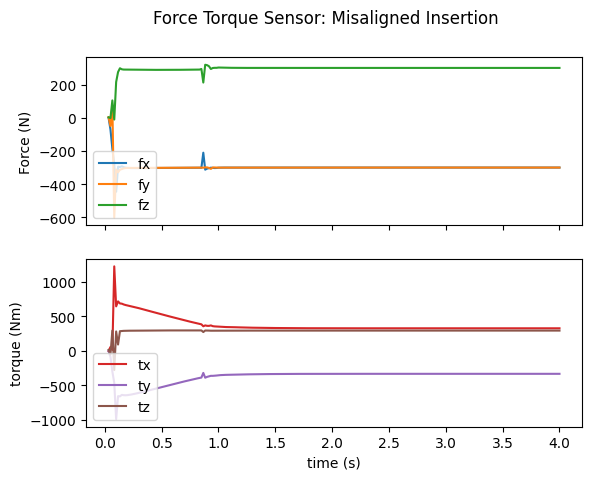

In [65]:
# @title Force torque data from misaligned plugging
# plot mj vs linear model
misaligned_sensor_data = np.array(sensor_data)
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

labels = ['fx', 'fy', 'fz']
ls = 'dotted'
for i in range(3):
    color = plt.get_cmap('tab10')(i)
    ax1.plot(t_vec[2:], misaligned_sensor_data[1:,i], color = color, label = labels[i-3])
ax1.set_ylabel('Force (N)')
ax1.legend(loc = 'lower left')

labels = ['tx', 'ty', 'tz']
for i in range(3):
    i = i + 3
    color = plt.get_cmap('tab10')(i)
    ax2.plot(t_vec[2:], misaligned_sensor_data[1:,i], color = color, label = labels[i-3])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('torque (Nm)');
ax2.legend(loc = 'lower left')

f.suptitle('Force Torque Sensor: Misaligned Insertion');

# Learning a Linear Contact Force Model
We are now going to try and solve for a smooth connector insertion by first bulding up a model of the contact forces. To do this, we are looking to learn a simple linear relationship between a feature vector containing the configuration $q$ and control $u$, and the predicted force torque sensor reading $\hat{s}$:
$$\begin{align}
\hat{s} = G \begin{bmatrix}q \\ u \\ 1 \end{bmatrix}
\end{align}$$
In general, this feature vector can include any desired nonlinearity and the model learning problem is still convex. This is because our model needs be linear *in* the feature vector, but the feature vector itself can contain anything we want it to. In order to build an estimate of $G$ online, we are going to use our LML algorithm to solve the following optimization problem:
<!-- $$\begin{align}
\min_G \quad \sum_i^N \|s_i - G \begin{bmatrix}q_i \\ u_i \\ 1 \end{bmatrix} \|_2^2 + \rho\|G\|_F^2
\end{align}$$

$$\begin{align}
\min_G \quad \overbrace{\sum_i^N \|s_i - G \begin{bmatrix}q_i \\ u_i \\ 1 \end{bmatrix} \|_2^2}^{\text{model error}} + \overbrace{\rho\|G\|_F^2}^{\text{regularizer}}
\end{align}$$ -->
$$\begin{align}
\min_G \quad \color{blue}{\overbrace{\color{black}{
    \sum_i^N \|s_i - G \begin{bmatrix}q_i \\ u_i \\ 1 \end{bmatrix} \|_2^2
}}^{\color{blue}{\text{model error}}}} + \color{red}{\overbrace{\color{black}{
    \rho\|G\|_F^2
}}^{\color{red}{\text{regularizer}}}}
\end{align}$$
as each new sensor measurement comes in, the LML algorithm will update the estimate of $G$ using entirely of paralellizable operations (there are no matrix inversions). This is worth noting because general systems with large feature or sensor dimensions can be efficiently handled on a GPU.

## Linear Model Learning (LML) algorithm

In [15]:
def get_cov_and_kalman_gain(sigma_bar, w):
    """Returns covariance and kalman gain in LML

    Args:
        sigma_bar: (_N_FEATURE, _N_FEATURE) predicted kf covariance
        w: (_N_FEATURE,) feature vector

    Returns:
        sigma_update: (_N_FEATURE, _N_FEATURE) updated covariance
        kalman_gain: (_N_FEATURE,) vector kalman gain

    Note:
        In the innovation covariance, the 1.0 comes from an identity sensor
        covariance. We get this through a change of variable as shown in the
        paper.
    """

    # innovation covariance (1.0 because our sensor noise is identity after)
    innovation_cov = w.T @ sigma_bar @ w + 1.0      # scalar

    # kalman_gain is a length _N_FEATURES vector
    kalman_gain = (sigma_bar @ w) / innovation_cov  # vector

    # covariance update (Joseph form for PSD stability)
    imlc = np.eye(len(w)) - np.outer(kalman_gain, w)
    sigma_update = imlc @ sigma_bar @ imlc.T + 1.0 * np.outer(
        kalman_gain, kalman_gain
    )

    return sigma_update, kalman_gain


def lml_step(mu_bar, sigma_bar, w, y):
    """LML step, where the mu_bar and sigma_bar are updated according to a new
    feature vector w and new measurement y.

    Args:
        mu_bars: (_N_MEASUREMENT, _N_FEATURE) predicted kf mean
        sigma_bar: (_N_FEATURE, _N_FEATURE) predicted kf covariance
        w: (_N_FEATURE,) feature vector
        y: (_N_MEASUREMENT,) measurement vector

    Returns:
        mu_bars: (_N_MEASUREMENT, _N_FEATURE) updated mean
        sigma_bar: (_N_FEATURE, _N_FEATURE) updated covariance

    Note:
        Unlike a normal Kalman Filter, the dimension of the belief mean is
        (_N_MEASUREMENT, _N_FEATURE), but the dimension of the covariance is
        (_N_FEATURE, _N_FEATURE). This is because really the covariance is a
        shared global covariance for each of the _N_MEASUREMENT rows in mu.
    """

    # use the feature vector to ge the updated covariance and kalman gain
    sigma_update, kalman_gain = get_cov_and_kalman_gain(sigma_bar, w)

    # innovation
    z = y - mu_bar @ w

    # update each mean with the kalman gain
    mu_updates = mu_bar + np.outer(z, kalman_gain)  # (6, N)

    return mu_updates, sigma_update

## Does a linear model really work for this?

In this section, we will fit a linear model to force torque sensor data from MuJoCo and see if we can really approximate this function as linear in our feature vector. Specifically, we are looking to approximate the following MuJoCo function:

```python
def mujoco_contact_force_model(model, data, q, v, u):
    # fill in data
    data.qpos = q
    data.qvel = v
    data.ctrl = u

    # take sim step
    mujoco.mj_step(model, data)

    # return the force torque sensor value
    return np.concatenate((
        data.sensor('force').data.copy(),
        data.sensor('torque').data.copy()
    ))
```

With the following linear function:
```python
def linear_contact_force_model(lml_mu, q, u):
    # create the feature vector
    feature_vector = np.concatenate((q, u, np.array([1])))

    # return the approximate force torque sensor value
    return lml_mu @ feature_vector
```
To do this, let's collect some data and fit the linear model to it.

In [16]:
def generate_calibration_controls(N):
    """create some sinusoids as a calibration manuever"""
    controls = np.zeros((N-1, 4))
    for i in range(N-1):
        controls[i,0] = -1.0 + np.sin(.04*i)/5
        controls[i,1] = np.sin(.5*i/10)/6
        controls[i,2] = np.cos(.3*i/7 + 0.4)/4
        controls[i,3] = np.cos(.5*i/7 - 1.0)/8

    return controls

In [17]:
# allocate configuration and sensor histories
q_hist = np.zeros((N, 4))
ft_hist = np.zeros((N, 6))
frames = []

# set initial condition
mujoco.mj_resetData(model, data)  # Reset state and time.
q_hist[0] = [-1., 0, 0, 0]
data.qpos = 1 * q_hist[0]

# filter initialization
_N_FEATURE = 9
_N_MEASUREMENT = 6
feature_vectors = np.zeros((N, _N_FEATURE))

lml_mu = np.zeros((_N_MEASUREMENT, _N_FEATURE))
lml_Sigma = (1/1e-1)*np.eye(_N_FEATURE) # regularized

controls = generate_calibration_controls(N)

# sim loop
for i in range(N-1):
    t = (i-1)*dt

    # corrupt the control signal with a misalignment
    controller_offset = np.array([0, -.4, .3, .2])
    controller_noise = 0.01*np.random.randn(4)
    data.ctrl = controls[i] + controller_offset

    # simulate and record force torque data
    mujoco.mj_step(model, data, nstep = mj_steps_per_call)

    q_hist[i+1] = data.qpos.copy()
    ft_hist[i+1] = np.concatenate((
        data.sensor('force').data.copy(),
        data.sensor('torque').data.copy()
    ))

    # update our estimated linear model
    feature_vectors[i+1] = np.concatenate((
        q_hist[i+1],  # 4
        controls[i], # 4
        np.array([1.0])
    ))

    lml_mu, lml_Sigma = lml_step(lml_mu , lml_Sigma, feature_vectors[i+1],
                                 ft_hist[i+1])

    # rendering stuff
    renderer.update_scene(data, "track", options)
    pixels = renderer.render()
    frames.append(pixels)


media.show_video(frames, fps=framerate, width = 500, height = 500)

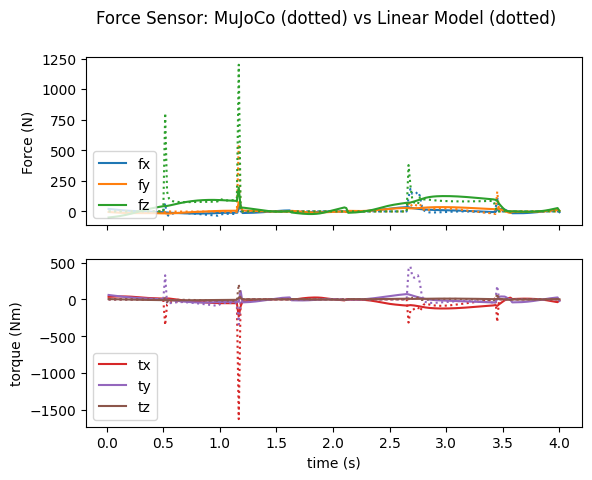

In [18]:
# @title Compare MuJoCo sensor values to those predicted by our linear model

# use our latest inear model (lml_mu[-1]) to predict force torque
fake_sensors = 0 * ft_hist
for i in range(ft_hist.shape[0]):
    fake_sensors[i] = lml_mu @ feature_vectors[i]

# plot mj vs linear model
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

labels = ['fx', 'fy', 'fz']
ls = 'dotted'
for i in range(3):
    color = plt.get_cmap('tab10')(i)
    ax1.plot(t_vec[1:], ft_hist[1:,i], linestyle = ls, color = color)
    ax1.plot(t_vec[1:], fake_sensors[1:,i], color = color, label = labels[i-3])
ax1.set_ylabel('Force (N)')
ax1.legend(loc = 'lower left')

labels = ['tx', 'ty', 'tz']
for i in range(3):
    i = i + 3
    color = plt.get_cmap('tab10')(i)
    ax2.plot(t_vec[1:], ft_hist[1:,i], linestyle = ls, color = color)
    ax2.plot(t_vec[1:], fake_sensors[1:,i], color = color, label = labels[i-3])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('torque (Nm)');
ax2.legend(loc = 'lower left')

f.suptitle('Force Sensor: MuJoCo (dotted) vs Linear Model (dotted)');

# Control

This fit looks more than good enough for control. We are going to use the following simple convex policy to solve for a control $u$ that minimize the force and torque values we care about:

<!-- $$
\begin{align}
\min_u \quad & \|SG \begin{bmatrix} q \\ u \\ 1 \end{bmatrix}\|_2^2 + 10^{-1}\|u - u_{old}\|_2^2 \\
 \text{st} \quad & -.1 \leq u - u_{old} \leq .1
\end{align}
$$ -->
$$
\begin{align}
\min_u \quad & \color{blue}{\overbrace{\color{black}{
    \|SG \begin{bmatrix} q \\ u \\ 1 \end{bmatrix}\|_2^2
}}^{\color{blue}{\text{minimize force/torque}}}} + \color{red}{\overbrace{\color{black}{
    10^{-1}\|u - u_{old}\|_2^2
}}^{\color{red}{\text{stay close to previous u}}}}\\
 \text{st} \quad & -.01 \leq u - u_{old} \leq .01
\end{align}
$$
where $S = \operatorname{diag}([1, 1, 0, 1, 1, 1])$ is used to select the elements of the force torque values we want to minimize, $G=$ `lml_mu` is our estimated linear model, $u_{old}$ is the previous control input.

In [ ]:
import cvxpy as cp

def policy(lml_mu, q, u_old, desired_pos_z):
    """policy where the linear model is used to solve for a control u that
    minimizes force and torque in every direction but z.

    Args:
        lml_mu: (_N_MEASUREMENT, _N_FEATURE) approximate linear model from lml
        q: (_N_q,) current configuration
        u_old: (_N_u,) previous control command

    Returns:
        u: (_Nu,) new control

    """

    # control we are solving for
    u = cp.Variable(4)

    # same feature vector as in the LML alg
    feature_vector = cp.hstack((
        q,
        u,
        np.array([1.0])
    ))

    # matrix from LML is used to predict the force torque
    ft = lml_mu @ feature_vector

    # cost the force and torque as well as regularizing around previous u
    force_torque_cost_term = cp.sum_squares(np.diag([1, 1, 0, 1, 1, 1]) @ ft)
    u_regularizer = 1e1*cp.sum_squares(u - u_old)
    cost = cp.Minimize(force_torque_cost_term + u_regularizer)

    # trust region constraint to ensure new control isn't too far from old
    # constraints = [cp.norm(u - u_old, np.inf) <= .001]
    constraints = [u - u_old <= 0.005, u - u_old >= -0.005]
    prob = cp.Problem(cost, constraints)
    prob.solve(solver = cp.CVXOPT)

    # use u[0] = position z to lower the plug following our schedule
    u = u.value
    u[0] = desired_pos_z

    return u


Now let's test this policy in sim where we will add a constant offset to the control signal, and white noise to both the controller as well as the sensor.

In [ ]:
frames = []

# set initial condition
mujoco.mj_resetData(model, data)  # Reset state and time.
data.qpos = [-1, 0, 0, 0.]

controls = np.zeros((N, 4))
controls[0] = np.array([-1, 0, 0, 0.])

# sim loop
for i in range(N-1):
    t = (i-1)*dt

    # corrupt the control signal with a misalignment
    controller_offset = np.array([0, -.4, .3, .2])

    # simulate and record force torque data
    desired_pos_z = max(-2,-1 - .25*t) # lower the plug to pos z = -2
    controls[i] = policy(lml_mu, q_hist[i], controls[i-1], desired_pos_z)
    data.ctrl = controls[i] + controller_offset

    mujoco.mj_step(model, data, nstep = mj_steps_per_call)

    q_hist[i+1] = data.qpos.copy()
    ft_hist[i+1] = np.concatenate((
        data.sensor('force').data.copy(),
        data.sensor('torque').data.copy()
    ))

    # update our estimated linear model
    feature_vectors[i+1] = np.concatenate((
        q_hist[i+1],  # 4
        controls[i], # 4
        np.array([1.0])
    ))

    lml_mu, lml_Sigma = lml_step(lml_mu , lml_Sigma, feature_vectors[i+1],
                                 ft_hist[i+1])

    # rendering stuff
    renderer.update_scene(data, "track", options)
    pixels = renderer.render()
    frames.append(pixels)


media.show_video(frames, fps=framerate, width = 500, height = 500)

# save this video for a later comparison
controlled_plugging_frames = frames.copy()

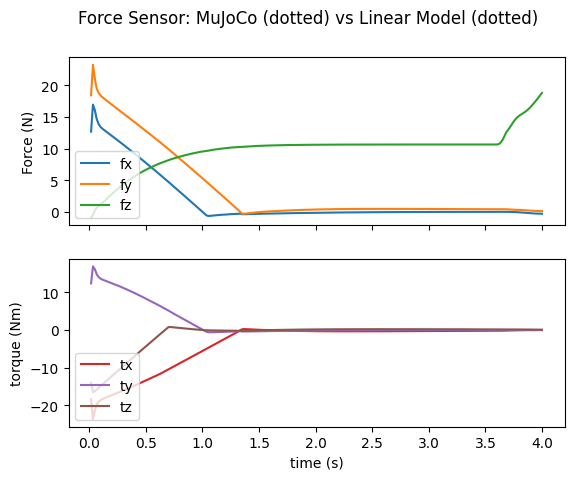

In [ ]:
# @title Force torque sensor data from controlled insertion


# plot mj vs linear model
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

labels = ['fx', 'fy', 'fz']
ls = 'dotted'
for i in range(3):
    color = plt.get_cmap('tab10')(i)
    ax1.plot(t_vec[1:], ft_hist[1:,i], color = color, label = labels[i-3])
ax1.set_ylabel('Force (N)')
ax1.legend(loc = 'lower left')

labels = ['tx', 'ty', 'tz']
for i in range(3):
    i = i + 3
    color = plt.get_cmap('tab10')(i)
    ax2.plot(t_vec[1:], ft_hist[1:,i], color = color, label = labels[i-3])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('torque (Nm)');
ax2.legend(loc = 'lower left')

f.suptitle('Force Sensor: MuJoCo (dotted) vs Linear Model (dotted)');

In [ ]:
# @title Visualize uncontrolled and controlled insertion
import cv2

joint_frames = []
for (nf, cf) in zip(naive_plugging_frames, controlled_plugging_frames):
    I = np.hstack((nf, cf))

    red_color = (159, 0, 0)
    left_box_pos = np.array([820, 900])
    left_box_width = 330
    left_box_height = 100
    left_pos_1 = left_box_pos + np.array([-left_box_width//2, left_box_height//2])
    left_pos_2 = left_box_pos + np.array([left_box_width//2, -left_box_height//2])
    I = cv2.rectangle(I, tuple(left_pos_1), tuple(left_pos_2), red_color, -1)

    I = cv2.putText(
        img = I,
        text = "baseline",
        org = (680, 915),
        fontFace = cv2.FONT_HERSHEY_COMPLEX,
        fontScale = 2.0,
        color = (255, 255, 255),
        thickness = 3
    )

    green_color = (0, 119, 0)
    left_box_pos = np.array([820 + 1060, 900])
    left_box_width = 200
    left_box_height = 100
    left_pos_1 = left_box_pos + np.array([-left_box_width//2, left_box_height//2])
    left_pos_2 = left_box_pos + np.array([left_box_width//2, -left_box_height//2])
    I = cv2.rectangle(I, tuple(left_pos_1), tuple(left_pos_2), green_color, -1)

    I = cv2.putText(
        img = I,
        text = "ours",
        org = (680 + 1120, 915),
        fontFace = cv2.FONT_HERSHEY_COMPLEX,
        fontScale = 2.0,
        color = (255, 255, 255),
        thickness = 3
    )

    joint_frames.append(I)


media.show_video(joint_frames, fps=framerate, width = 1000, height = 500)

## Controller with Noise
Now we will add white noise to the state estimate, the force torque sensor measurement, and the control signal. Despite the noise on all of these sources, the controller still performs just fine.

In [ ]:
frames = []

# set initial condition
mujoco.mj_resetData(model, data)  # Reset state and time.
data.qpos = [-1, 0, 0, 0.]

controls = np.zeros((N, 4))
controls[0] = np.array([-1, 0, 0, 0.])

# sim loop
np.random.seed(seed = 1234)
for i in range(N-1):
    t = (i-1)*dt

    # corrupt the control signal with a misalignment
    controller_offset = np.array([0, -.4, .3, .2])

    # simulate and record force torque data
    desired_pos_z = max(-2,-1 - .25*t) # lower the plug to pos z = -2
    controls[i] = policy(lml_mu, q_hist[i], controls[i-1], desired_pos_z)
    data.ctrl = controls[i] + controller_offset + .01*np.random.randn(4)

    mujoco.mj_step(model, data, nstep = mj_steps_per_call)

    # put noise on state estimate and sensor measurement
    q_hist[i+1] = data.qpos.copy() + .01*np.random.randn(4)
    ft_hist[i+1] = np.concatenate((
        data.sensor('force').data.copy(),
        data.sensor('torque').data.copy()
    )) + .01*np.random.randn(6)

    # update our estimated linear model
    feature_vectors[i+1] = np.concatenate((
        q_hist[i+1],  # state estimate noise
        controls[i], # 4
        np.array([1.0])
    ))

    lml_mu, lml_Sigma = lml_step(lml_mu , lml_Sigma, feature_vectors[i+1],
                                 ft_hist[i+1])

    # rendering stuff
    renderer.update_scene(data, "track", options)
    pixels = renderer.render()
    frames.append(pixels)


media.show_video(frames, fps=framerate, width = 500, height = 500)

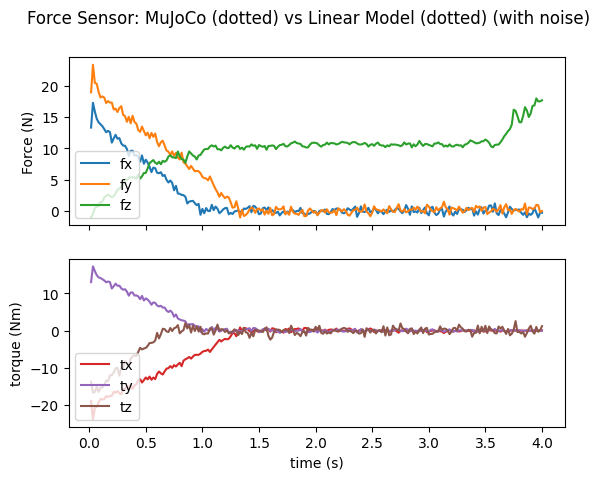

In [ ]:
# @title Force torque sensor data from controlled insertion (with noise)


# plot mj vs linear model
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

labels = ['fx', 'fy', 'fz']
ls = 'dotted'
for i in range(3):
    color = plt.get_cmap('tab10')(i)
    ax1.plot(t_vec[1:], ft_hist[1:,i], color = color, label = labels[i-3])
ax1.set_ylabel('Force (N)')
ax1.legend(loc = 'lower left')

labels = ['tx', 'ty', 'tz']
for i in range(3):
    i = i + 3
    color = plt.get_cmap('tab10')(i)
    ax2.plot(t_vec[1:], ft_hist[1:,i], color = color, label = labels[i-3])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('torque (Nm)');
ax2.legend(loc = 'lower left')

f.suptitle('Force Sensor: MuJoCo (dotted) vs Linear Model (dotted) (with noise)');